# Tennis. Collaboration and Competition
---

In this notebook, we use and learn how to use the Unity ML-Agents Tennis environment for the third project of the Udacity's [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt

import torch

from ddpg_agent import Agent
from collections import deque

Next, we will start the environment! **Before running the code below**, change the `ENV_FILE` parameter to match the location of the Unity enviroment that you downloaded

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
ENV_FILE = './env/Tennis.app'
env = UnityEnvironment(file_name=ENV_FILE)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain brains which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In the environment, we have two agents controlling rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of `+0.1`. If an agent lets the ball hit the ground or hits the ball out of bounds, it receives a reward of `-0.1`. 
We have `2` agents, and the action space is of size `2` (continuous, corresponding to movement toward/away from the net and jumping).
The state space has a lenght of `24` variables for position and velocities of the racket and ball. Each agent receives its own local observation so, in every step, we get two observations from the environment. 

Run the code cell below to print some information about the environment.

In [4]:
# Reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents: ', num_agents)


# size of each action
action_size = brain.vector_action_space_size
print('Size of each action: ', action_size)

# examine the state space
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with lenght: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])



Number of agents:  2
Size of each action:  2
There are 2 agents. Each observes a state with lenght: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Train the agent

#### Function with the main loop and the training process.

In [2]:
def ddpg(env, n_episodes=500, max_t=200, train_mode=True):
#     env = UnityEnvironment(file_name='./env/Tennis.app')
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    action_size = brain.vector_action_space_size
    env_info = env.reset(train_mode=train_mode)[brain_name]

    states = env_info.vector_observations

    agent = Agent(state_size=states.shape[1], action_size=action_size, random_seed=2)

 
    brain_name = env.brain_names[0]
    scores = []
    scores_deque = deque(maxlen=100)
    scores_mean = []
    max_score = -np.Inf
    

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]
        num_agents = len(env_info.agents)
#         agent.reset()
        score = np.zeros((2,))
        states = env_info.vector_observations
        for t in range(max_t):
            agent.reset()
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states= env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += env_info.rewards
            if np.any(dones):
                break
        scores_deque.append(np.max(score))
        scores_mean.append(np.mean(scores_deque))
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {}'.format(i_episode, np.mean(scores_deque), score), end="")
        
        # We save the best weights
        if np.max(score)> max_score:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_best.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_best.pth') 
            print('\rSaving Weights for max score old: {} -> new: {} '.format(max_score, np.max(score)))
            max_score = np.max(score)

        # We also save weights evety 100 episodes
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {}'.format(i_episode, np.mean(scores_deque), score), end="")
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
        
        # We test if we have solved the environment
        if np.mean(scores_deque)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break

#     env.close()
    return scores, scores_mean



We call the function to train the agent

In [3]:
scores, sc_mean = ddpg(env, n_episodes=3500, max_t=500)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Saving Weights for max score old: -inf -> new: 0.0 
Saving Weights for max score old: 0.0 -> new: 0.09000000171363354 
Saving Weights for max score old: 0.09000000171363354 -> new: 0.10000000149011612 
Episode 100	Average Score: 0.01	Score: [ 0.   -0.01]
Episode 200	Average Score: 0.00	Score: [-0.01  0.  ]
Episode 300	Average Score: 0.01	Score: [-0.01  0.1 ]
Episode 400	Average Score: 0.04	Score: [-0.01  0.  ]
Episode 500	Average Score: 0.01	Score: [0.   0.09]1]
Saving Weights for max score old: 0.10000000149011612 -> new: 0.20000000298023224 
Saving Weights for max score old: 0.20000000298023224 -> new: 0.30000000447034836 
Episode 600	Average Score: 0.06	Score: [ 0.1  -0.01]
Episode 700	Average Score: 0.09	Score: [ 0.1  -0.01]
Saving Weights for max score old: 0.30000000447034836 -> new: 0.4000000059604645 
Episode 800	Average Score: 0.11	Score: [ 0.1  -0.01].40000001]
Saving Weights for max score old: 0.4000000059604645 -> new: 0.5000000074505806 
Saving Weights for max score old: 0

#### We plot the scores

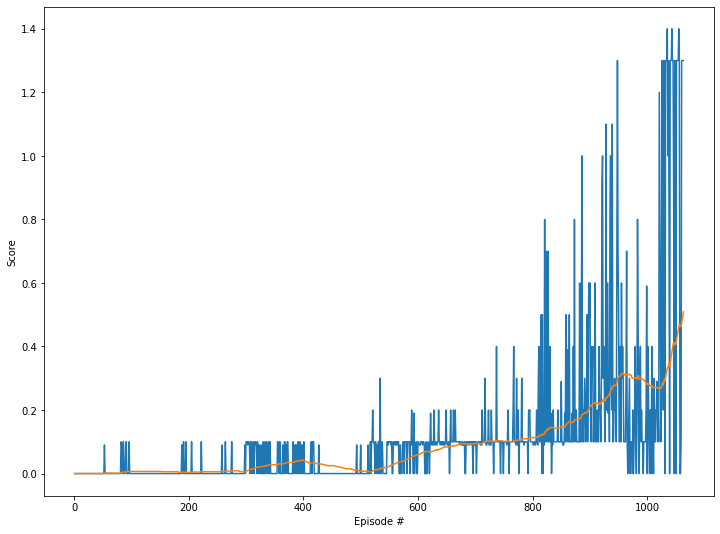

In [4]:

scores = np.max(np.array(scores),axis=1)
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(sc_mean)+1), sc_mean)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('train_scores.png')
plt.show()

### 4. Watch them play!

In the next code cell, we load some trained weights from file to watch an smart agent play some episodes

In [16]:
for i in range(10):                                    
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    action_size = brain.vector_action_space_size

# play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    num_agents = len(env_info.agents)
    states = env_info.vector_observations                  # get the current state (for each agent)

    agent = Agent(state_size=states.shape[1], action_size=action_size, random_seed=2)
    agent.actor_local.load_state_dict(torch.load('checkpoint_actor_best.pth'))
    agent.critic_local.load_state_dict(torch.load('checkpoint_critic_best.pth'))


    
    scores = []
    score = np.zeros((2,))

    while True:
#         agent.reset()   
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]
        states = env_info.vector_observations
        score += np.array(env_info.rewards)
        dones = env_info.local_done
        if np.sum(dones) > 0:
            break
    print('Scores: {}'.format(score))



Scores: [-0.01  0.  ]
Scores: [ 0.   -0.01]
Scores: [ 0.   -0.01]
Scores: [-0.01  0.  ]
Scores: [-0.01  0.  ]
Scores: [ 0.   -0.01]
Scores: [ 0.   -0.01]
Scores: [-0.01  0.  ]
Scores: [ 0.   -0.01]
Scores: [ 0.   -0.01]


In [ ]:
env.close()